In [15]:
from typing import Annotated, Sequence, TypedDict, Optional, Union
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage, SystemMessage
from datetime import date, datetime
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig

<h2>Populating the database</h2>

In [8]:
import os, shutil, sqlite3
import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
backup_file = "travel2.backup.sqlite"
overwrite = False

if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()
    with open(local_file, "wb") as f:
        f.write(response.content)
    shutil.copy(local_file, backup_file)

#Converting the flight times to present time
def update_datetime(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.to_list()


    tdf ={}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival"
    ]

    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    
    del df
    del tdf
    conn.commit()
    conn.close()

    return file

db = update_datetime(local_file)



<h2>Flight tools</h2>

In [ ]:
@tool
def flights_search(
    dep_airport : Optional[str] = None,
    arr_airport : Optional[str] = None,
    dep_start_datetime : Optional[date | datetime] = None,
    dep_end_datetime : Optional[date | datetime] = None,
    arr_start_datetime : Optional[date | datetime] = None,
    arr_end_datetime : Optional[date | datetime] = None,
    limit : int = 20,
) -> list[dict]:
    """Searches for flights based on given parameters such as departure airport, arrival airport. It also considers the preferred time range of departure of the flight as well as the preferred time range of arrival."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if dep_airport:
        query += "AND departure_airport = ?"
        params.append(dep_airport)
    
    if arr_airport:
        query += "AND arrival_airport = ?"
        params.append(arr_airport)

    if dep_start_datetime:
        query += "AND scheduled_departure >= ?"
        params.append(dep_start_datetime)
    
    if dep_end_datetime:
        query += "AND scheduled_departure <= ?"
        params.append(dep_end_datetime)

    if arr_start_datetime:
        query += "AND scheduled_arrival >= ?"
        params.append(arr_start_datetime)
    
    if arr_end_datetime:
        query += "AND scheduled_arrival <= ?"
        params.append(arr_end_datetime)

    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

<h2>Hotel Tools</h2>

In [13]:
@tool
def hotel_search(
    location: Optional[str] = None,
    check_in_datetime: Optional[Union[datetime, date]] = None,
    check_out_datetime: Optional[Union[date, datetime]] = None,
    price_tier: Optional[str] =None,
    limit: int = 20
)-> list[dict]:
    """This function searches for hotels based on given information like location, expected price tier (Luxury, Upscale, Midscale, etcetera) and the expected check in date and check out date."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()
    query = "SELECT * FROM hotels WHERE 1 = 1"
    params = []

    if location:
        query += "AND location = ?"
        params.append(location)
    
    if check_in_datetime:
        query += "AND checkin_date = ?"
        params.append(check_in_datetime)
    
    if check_out_datetime:
        query += "AND checkout_date = ?"
        params.append(check_out_datetime)
    
    if price_tier:
        query += "AND price_tier = ?"
        params.append(price_tier)
    
    query += " LIMIT ?"
    params.append(limit)

    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


<h2>Utilities Section</h2>

In [28]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

<h2>Defining Agent State</h2>

In [14]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage], add_messages]

<h2>Defining Agent Class</h2>

In [ ]:
from langchain_core.runnables import Runnable, RunnableConfig

class llmAssistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

llm = ChatOllama(model="qwen2.5:0.5bm", temperature=1)

def call_model(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(
        content = f"""
        You are a helpful customer support bot for Jetstar Airlines.
        Use the provided tools to search for flights, hotels and other information to assist the user's queries.
        \nCurrent time: {datetime.now}
        """
        )
    response = llm.invoke([system_prompt] + state["messages"])
    return {"messages":response}

zero_shot_agent_tools = [
    hotel_search,
    flights_search
]

<h2>Defining the State Graph of the Agent</h2>

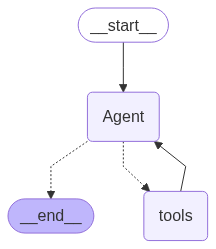

In [27]:
from langgraph.prebuilt import tools_condition, ToolNode

graph = StateGraph(AgentState)

graph.add_node("Agent", call_model)
tool_node = ToolNode(tools=zero_shot_agent_tools)
graph.add_node("tools", tool_node)

graph.add_edge(START, "Agent")
graph.add_conditional_edges(
    "Agent",
    tools_condition,
)
graph.add_edge("tools", "Agent")

app = graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

<h2>Actually calling the damn agent and making it all work</h2>